In [98]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import trackpy as tp
from matplotlib import cm

## 1 MSD

### 1.1 Direct comparison

In [8]:
folder = r'C:\Users\liuzy\Dropbox\Fluctuation Bacterial Droplets\Analysis\0001'
data_m = pd.read_csv(os.path.join(folder, 'MSD_m1.csv'), names=['x', 'y', 'z', 't'])
data_p = pd.read_csv(os.path.join(folder, 'MSDp.csv'))

In [9]:
data_m = data_m.assign(msd=np.sum(data_m[['x', 'y', 'z']], axis=1))

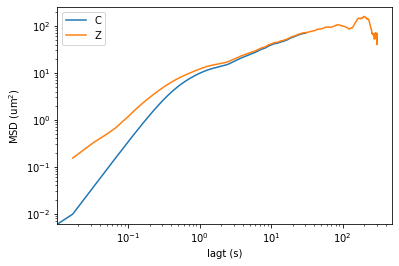

In [10]:
plt.plot(data_m.t, data_m.msd, label='C')
plt.plot(data_p.lagt, data_p.msd, label='Z')
plt.loglog()
plt.xlabel('lagt (s)')
plt.ylabel('MSD (um$^2$)')
plt.legend()

### 1.2 MSD with smooth trajectories

It's believed that the diffusive/subdiffusive regime at short lag time in my MSD curve is due to noise, which can be fixed by applying smoothing to the trajectories of particles. Here we test this hypothesis.

### 1.2.1 smoothn

**A side note on `smoothn`**

`smoothn` is a robust spline smoothing function borrowed from MATLAB. Its return value is a 4-tuple, where the first element is the smoothed array, of the input array size. To use it in the simplest way, do `smoothed_data = smoothn(input_data)`. If multi-dimensional array is used as the input, do `smoothed_data = smoothn(input_data, axis=0)` and specify the axis number carefully.

In [12]:
from smoothn import smoothn

In [13]:
# read parameters
folder = r'C:\Users\liuzy\Dropbox\Fluctuation Bacterial Droplets'
data_folder = os.path.join(folder, 'Data')
params = pd.read_csv(os.path.join(data_folder, 'Parameters.csv'))
params.head()

,Exp,OD,Fps,Ro
0,1,36,60,16.310435
1,2,14,60,12.059316
2,3,14,60,16.166276
3,4,14,60,13.830312
4,5,14,60,14.208787


In [14]:
# load trajectory
traj = pd.read_csv(os.path.join(data_folder, 'exp1.csv'), 
                   names=['x', 'y', 'z'])
# smooth trajectory data with smoothn function
traj_s_array = smoothn(traj, nS0=35, axis=0)[0] 
traj_s = pd.DataFrame(traj_s_array, columns=['x', 'y', 'z'])

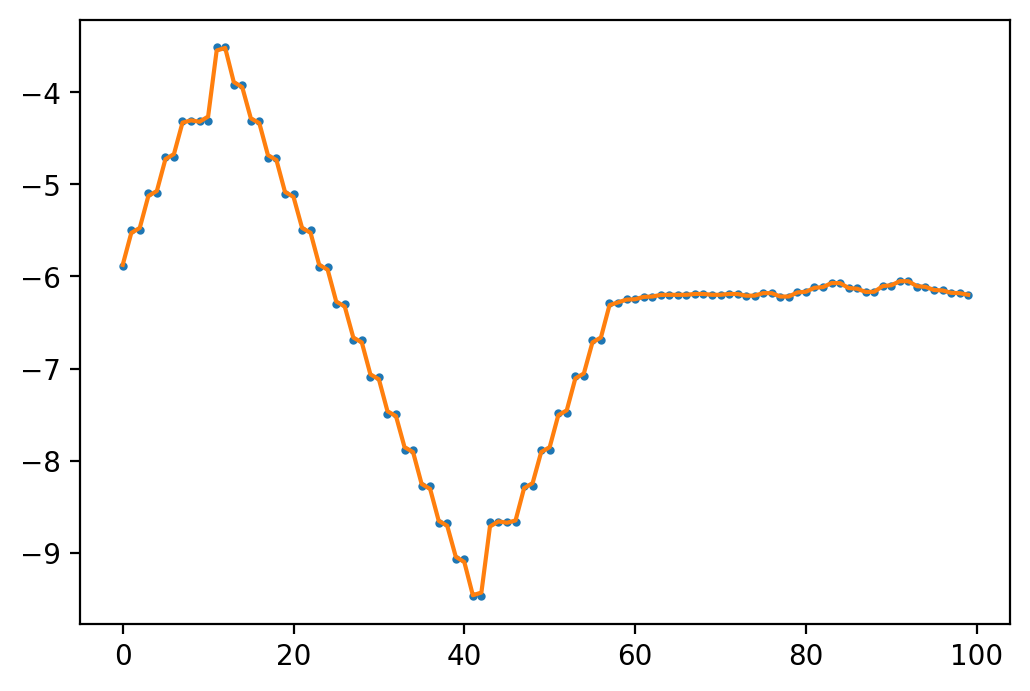

In [15]:
plt.figure(dpi=200)
plt.plot(traj.z[:100], marker='o', ls='', markersize=2)
plt.plot(traj_s.z[:100])

In [16]:
traj_s = traj_s.assign(particle=0, frame=traj_s.index)
msd = tp.msd(traj_s, pos_columns=['x', 'y', 'z'], mpp=1, fps=60, max_lagtime=len(traj_s)//10)

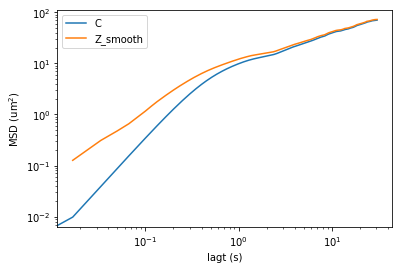

In [17]:
plt.plot(data_m.t, data_m.msd, label='C')
plt.plot(msd.lagt, msd.msd, label='Z_smooth')
plt.loglog()
plt.xlabel('lagt (s)')
plt.ylabel('MSD (um$^2$)')
plt.legend()

**Comment:** the results are still not consistent at small time regime. We figured that `smoothn` does not significantly smooth the trajectory data. Try savgol filter now.

### 1.2.2 Savgol filter

In [66]:
from myImageLib import gauss1
from scipy.signal import savgol_filter

Text(0, 0.5, 'x (um)')

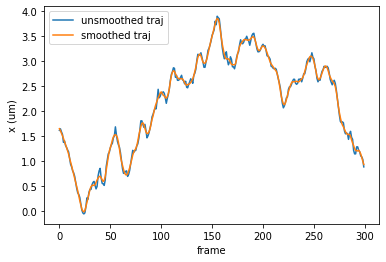

In [117]:
y = savgol_filter(traj.x, 11, 3)
plt.plot(traj.x[:300], label='unsmoothed traj')
plt.plot(y[:300], label='smoothed traj')
plt.legend()
plt.xlabel('frame')
plt.ylabel('x (um)')

Text(0, 0.5, 'x (um)')

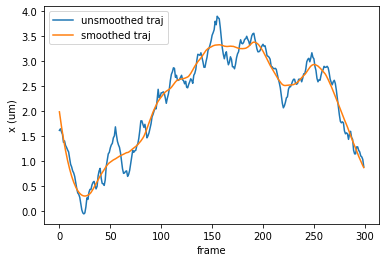

In [118]:
y = savgol_filter(traj.x, 61, 3)
plt.plot(traj.x[:300], label='unsmoothed traj')
plt.plot(y[:300], label='smoothed traj')
plt.legend()
plt.xlabel('frame')
plt.ylabel('x (um)')

Text(0, 0.5, 'x (um)')

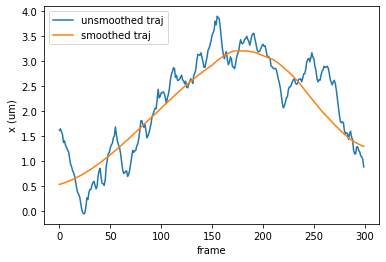

In [119]:
y = savgol_filter(traj.x, 301, 3)
plt.plot(traj.x[:300], label='unsmoothed traj')
plt.plot(y[:300], label='smoothed traj')
plt.legend()
plt.xlabel('frame')
plt.ylabel('x (um)')

In [85]:
# smooth all coordinates
traj_s_dict = {}
for coor in traj:
    traj_s_dict[coor] = savgol_filter(traj[coor], 35, 3)
traj_s = pd.DataFrame(traj_s_dict)

#### compare the MSD's of the same trajectory with different degrees of smoothing

In [114]:
smoothing_windows = np.arange(10, 300, 30) + 1

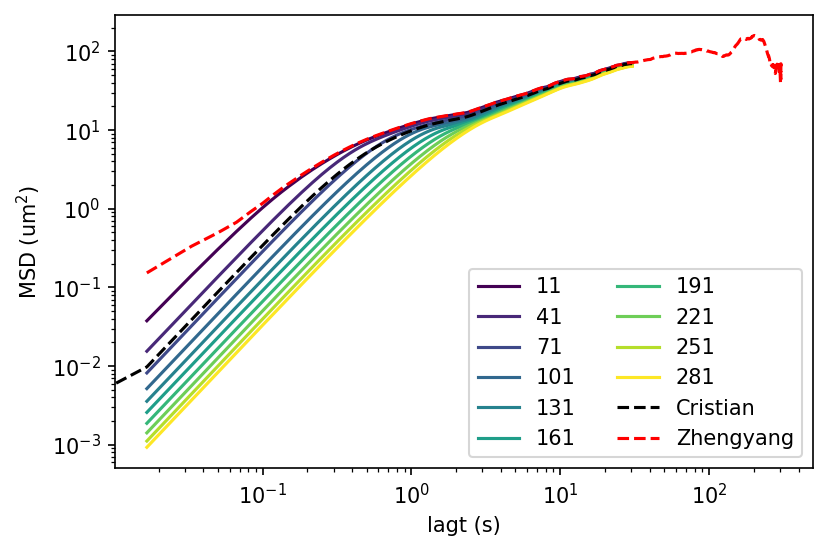

In [121]:
plt.figure(dpi=150)
viridis = cm.get_cmap('viridis', len(smoothing_windows))
for i, w in enumerate(smoothing_windows):
    traj_s_dict = {}
    for coor in traj:
        traj_s_dict[coor] = savgol_filter(traj[coor], w, 3)
    traj_s = pd.DataFrame(traj_s_dict)
    traj_s = traj_s.assign(frame=traj_s.index, particle=0)
    msd = tp.msd(traj_s, pos_columns=['x', 'y', 'z'], mpp=1, fps=60, max_lagtime=len(traj_s)//10)
    plt.plot(msd.lagt, msd.msd, label=w, color=viridis(i))
plt.plot(data_m.t, data_m.msd, label='Cristian', color='black', ls='--')
plt.plot(data_p.lagt, data_p.msd, label='Zhengyang', color='red', ls='--')
plt.loglog()
plt.xlabel('lagt (s)')
plt.ylabel('MSD (um$^2$)')
plt.legend(ncol=2)

**Comments:** so it's clear that the difference in the small time regime is a result of smoothing. 
- Smooth the trajectory with savgol filter of window ~60 can reproduce Cristian's result. However, according to the curves in the above plot for different smoothing window sizes, that result is not "the best", but one of the various results that show ballistic motions.
- The unsmoothed data at the smallest lagt is around 0.16 um$^2$. This is consistent with the step size of the tracking device (0.4 um/frame), so very likely this is the cause of the diffusive/subdiffusive motion of observed from the tracks at small lagt. We can do smoothing in analysis to remove the unreal diffusive/subdiffusive motions. Alternatively, we can reduce the step size of tracking in experiment, which will also likely to reveal the ballistic regime.

### 1.3 Remove outliers (in progress)

#### 1.3.1 Z-score

In [97]:
from scipy import stats

In [117]:
z=np.abs(stats.zscore(traj_s))

<AxesSubplot:ylabel='Frequency'>

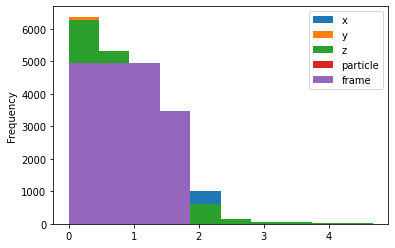

In [118]:
(z).plot.hist()

In [119]:
traj_rm = traj_s[z<3]

<AxesSubplot:ylabel='Frequency'>

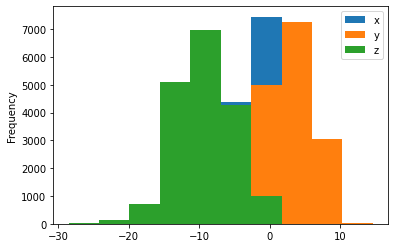

In [120]:
traj.plot.hist()

<AxesSubplot:ylabel='Frequency'>

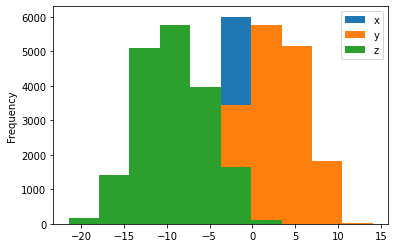

In [122]:
traj_rm[['x', 'y', 'z']].plot.hist()

<AxesSubplot:ylabel='Frequency'>

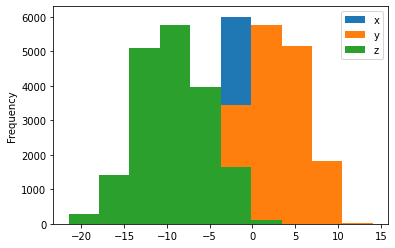

In [124]:
# fill data
traj_rm_fill = traj_rm.fillna(method="pad")
traj_rm_fill[['x', 'y', 'z']].plot.hist()

In [125]:
msd = tp.msd(traj_rm_fill, pos_columns=['x', 'y', 'z'], mpp=1, fps=60, max_lagtime=len(traj_s)//10)

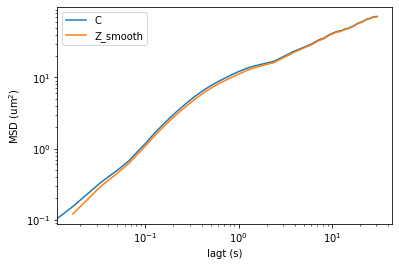

In [157]:
plt.plot(data_m.t, data_m.msd, label='C')
plt.plot(msd.lagt, msd.msd, label='Z_smooth')
plt.loglog()
plt.xlabel('lagt (s)')
plt.ylabel('MSD (um$^2$)')
plt.legend()